In [25]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import random
import math
import torch
import copy
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.svm import SVC

import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

import mads_dl

from PIL import Image
from IPython.display import Image
import matplotlib.cm as cm
import seaborn as sns

# set all columns to be displayed
pd.set_option('display.max_columns', None)

# Classes

## Loading Data Classes

In [73]:
class LoadData:
    def __init__(self):
        """
        Initializes the LoadData class.
        
        This class provides methods for loading data files and retrieving
        information related to specific files, including data descriptions
        and substrate lists.
        """
        pass

    def load_data(self, endswith:str):
        """
        Loads all files from the 'Data' directory that have the specified file extension.

        This function searches through the 'Data' directory (one level up from the
        current working directory) for files that match the specified file extension.
        It collects the paths of these files and returns them as a list.

        Example files:
            - 'FA_20231113_2H_yeast_Pyruvate-d3_1.csv'

        Args:
            endswith (str): The file extension to filter by (e.g., '.csv').

        Returns:
            list: A list of file paths in the 'Data' directory that end with the specified extension.
        """
        path_list = []
        cwd = Path(os.getcwd())
        print(f'Working Dir: {cwd}')
        data_path = os.path.join(cwd.parent, 'Data')

        print(f'Path: {data_path}')
        for root, dirs, files in os.walk(data_path):
            for file in files:
                if file.endswith(endswith):
                    file_path = os.path.join(root, file)
                    path_list.append(file_path)
        return path_list

    def load_DataDescription(self):
        """
        Loads the 'DataDescription.csv' file as a pandas DataFrame.

        This function reads 'DataDescription.csv' from the 'Data' directory located
        one level up from the current working directory. It returns the file's content
        as a pandas DataFrame.

        Returns:
            pd.DataFrame: A DataFrame containing the data from 'DataDescription.csv'.
        """
        data_description_path = os.path.join(os.getcwd(), '..', 'Data', 'Data_description.xlsx')
        data_description = pd.read_excel(data_description_path, engine='openpyxl')
        return data_description

    def get_substrate_list(self, file:str):
        """
        Retrieves substrate information related to the specified file.

        This function loads data from the 'DataDescription.csv' file, filtering
        rows based on the specified file name. It then extracts the substrate's
        chemical shift (ppm) and water chemical shift (ppm) values, returning them
        as a list.

        Args:
            file (str): The name of the file for which to retrieve substrate information.

        Returns:
            list: A list containing the substrate chemical shift (ppm) and water chemical shift (ppm) as floats.
        """
        data_desc = self.load_DataDescription()
        
        # Filter by file name
        data_desc = data_desc.loc[data_desc['File'] == file].reset_index(drop=True)

        substrat_shift = data_desc.at[0, 'Substrate_chemical shift (ppm)']
        substrat_water = data_desc.at[0, 'Water_chemical shift (ppm)']

        def clean_list(value):
            # Convert value to float
            return float(value)
        
        substrat_shift = clean_list(substrat_shift)
        substrat_water = clean_list(substrat_water)

        # Return as list
        substrates = [substrat_shift, substrat_water]
   
        return substrates
    

    def get_metabolite_list(self, file):
        """
        Retrieves a list of metabolite chemical shifts (ppm) associated with the specified file.

        This method loads data from the 'DataDescription.csv' file and filters it by the specified file name.
        It then extracts all columns containing metabolite information (columns with 'Metabolite' and 'ppm' in
        the name) and returns their values as a list of floats, excluding any NaN values.

        Args:
            file (str): The name of the file for which to retrieve metabolite chemical shift information.

        Returns:
            list: A list of metabolite chemical shift values (in ppm) as floats, excluding NaN values.
    """
        
        data_desc = self.load_DataDescription()
        
        # Filter by file name
        data_desc = data_desc.loc[data_desc['File'] == file].reset_index(drop=True)

        # get all cols which contains Metabolite and ppm
        cols = [col for col in data_desc.columns if 'Metabolite' in col and 'ppm' in col]
        metabolites = []
        for col in cols:
            metabolites.append(data_desc.at[0, col])
        
        # to float
        metabolites = [float(metabolite) for metabolite in metabolites]

        # remove nan values
        metabolites = [metabolite for metabolite in metabolites if not math.isnan(metabolite)]

        return metabolites


LoadData = LoadData()


In [74]:
LoadData.get_metabolite_list('FA_20231113_2H_yeast_Pyruvate-d3_1.csv')

[1.2261, 1.9775]

# Step 1: Loading the data

In [ ]:


path_list = load_data('FA_20231113_2H_yeast_Pyruvate-d3_1.csv')
print(path_list)

Working Dir: /home/generalpegasus/Documents/Programme/MoinCC-AI4metabolomics/03_DeepLearning
Path: /home/generalpegasus/Documents/Programme/MoinCC-AI4metabolomics/Data
['/home/generalpegasus/Documents/Programme/MoinCC-AI4metabolomics/Data/FA_20231113_2H_yeast_Pyruvate-d3_1.csv']


In [628]:
# shapes of all the csv files
path_list2 = load_data('.csv')

for path in path_list2:
    df = pd.read_csv(path)
    print(df.shape)

Working Dir: /home/generalpegasus/Documents/Programme/MoinCC-AI4metabolomics/03_DeepLearning
Path: /home/generalpegasus/Documents/Programme/MoinCC-AI4metabolomics/Data
(1297, 131)
(1714, 131)
(632, 51)
(1429, 131)
(628, 51)
(654, 51)
(960, 131)
(1279, 131)
(622, 51)
(1478, 131)
(1796, 101)
(841, 41)
(1902, 131)
(1226, 131)
(823, 131)
(1796, 101)
(1074, 131)
(880, 131)
(778, 131)
(778, 51)
(735, 131)
(653, 131)
(1045, 131)
(695, 131)
(1632, 131)
(1632, 131)
(1583, 131)
(1594, 131)
(1675, 131)
(1503, 131)
(637, 51)
(755, 131)
(620, 51)
(2004, 131)
(922, 131)
(705, 131)
(1583, 131)
(908, 51)
(1913, 131)
(855, 131)
(877, 40)
(799, 131)
(1714, 131)
(1913, 131)
(447, 51)


In [629]:
for file in path_list:
    df = pd.read_csv(file)
    print(df.shape)

(1503, 131)


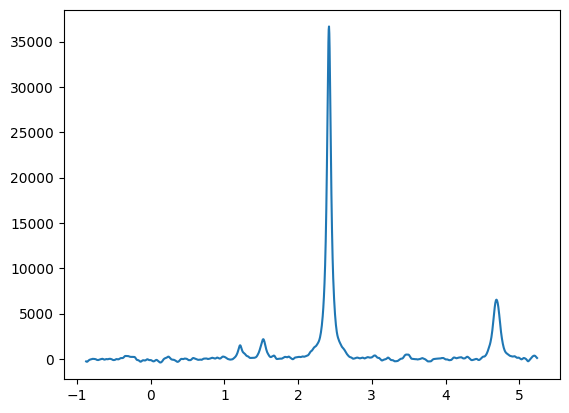

In [630]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    df['sum'] = df.iloc[:,1:].sum(axis=1)

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)


plt.show()

In [631]:
df['sum']

0       -852.953510
1      -1168.218890
2      -1524.973790
3      -1905.063789
4      -2313.660113
           ...     
1498    6968.597040
1499    6811.509176
1500    6645.824694
1501    6291.822860
1502    5931.063100
Name: sum, Length: 1503, dtype: float64

# Step 2: Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

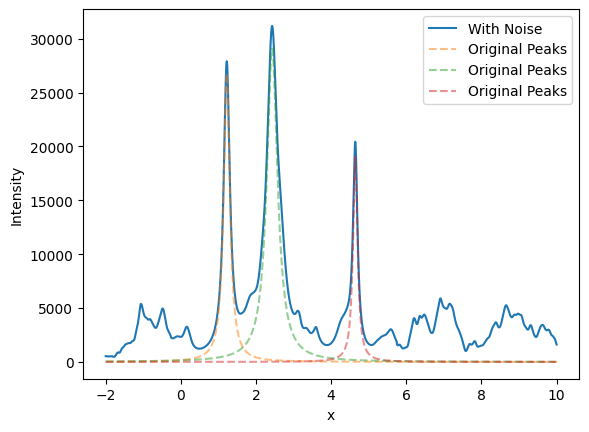

In [632]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma**2 / ((x - x0)**2 + gamma**2))


def generate_random_spectrum(peak_list, spectrum_length=3000):
    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 10, spectrum_length)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    x0_parms = []
    gamma_parms = []
    height_parms = []

    for peak_pos in peak_list:
        metabolism_x0 = peak_pos + np.random.uniform(-0.1, 0.1)
        
        metabolism_gamma = np.random.uniform(0.05, 0.2)  # Random width (gamma)
        metabolism_height = np.random.uniform(0, 40000)  # Random height
        peak_lorenz = lorentzian(x, metabolism_x0, metabolism_gamma, metabolism_height)
        y += peak_lorenz

        
        # Add more peaks with lower height
        # create random integer between 1 and 8
        num_peaks = np.random.randint(1, 5)
        for _ in range(num_peaks):
            for _ in range(8):
                x0 = np.random.uniform(-2, 10)
                gamma = np.random.uniform(0.05, 0.2)
                height = np.random.uniform(0, 2000)
                y += lorentzian(x, x0, gamma, height)

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak_lorenz > (0.1 * height)  # Masking regions where peak height is significant

        # Append the parameters for the peak
        x0_parms.append(metabolism_x0)
        gamma_parms.append(metabolism_gamma)
        height_parms.append(metabolism_height)
        

    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(100, spectrum_length)
    noise = np.random.normal(10, random_noise_level, spectrum_length)

    # smooth the noise with gaussian filter
    sigma = random_noise_level / 100
    noise = gaussian_filter1d(noise, sigma=sigma)
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    return x, y_noisy, np.array(x0_parms), np.array(gamma_parms), np.array(height_parms)


# ----

#peak_list = [2.323, 4.7, 1.201]
pyruvate_list = [1.2261, 2.468, 4.7]
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(pyruvate_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


# Step 3: Fill Up Original Data 

          x           y
0 -2.000000 -200.830686
1 -1.995927 -204.426474
2 -1.991855 -208.331423
3 -1.987782 -207.962925
4 -1.983710 -200.187011


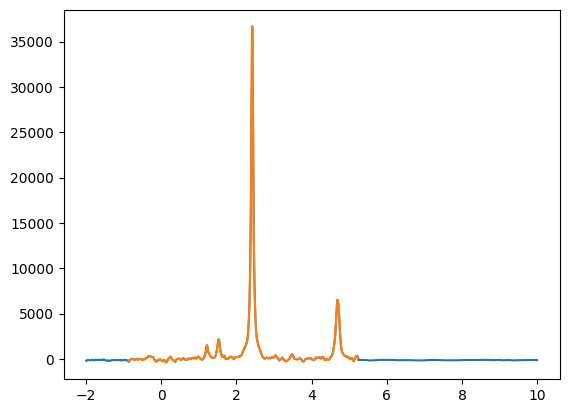

(2949, 2)


In [633]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=3000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)
    
    df = pd.DataFrame({'x': x_new, 'y': interpolated_data})
    return df

def fill_df(df):
    """If Data is not ranging from -2 to 10, fill the data with noise
    
    """
    # renmame the columns
    df.columns = ['x', 'y']
    x = df.loc[:, 'x']
    y = df.loc[:, 'y']



    # Calculate the step size of the x values
    x_diff = np.diff(x)
    step = np.mean(x_diff)
    
    # Take sample range for the noise
    x_range_lower = 20
    x_range_upper = 100

    # get sample data of the noise
    x_sample = x[x_range_lower:x_range_upper]
    y_sample = y[x_range_lower:x_range_upper]

    # get the max and min values of the sample data
    y_min, y_max = y_sample.min(), abs(y_sample.min())
    x_min, x_max = x_sample.min(), abs(x_sample.min())

    if x_min > -2:

        # create values in n steps
        x_new = np.arange(-2, x.iloc[0], step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(y_min, y_max, len(x_new))
        
        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([data, df], axis=0)
        df.reset_index(drop=True, inplace=True)

    if x_max < 10:
    
        # create values in n steps
        x_new = np.arange(x.iloc[-1], 10, step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(y_min, y_max, len(x_new))

        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([df, data], axis=0)
        df.reset_index(drop=True, inplace=True)
                
    return df


df_fill = df.iloc[:, 0:2]
#print(df_fill.head())
df_filled = fill_df(df_fill)
print(df_filled.head())

# plot 
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1])
plt.show()
print(df_filled.shape)


# Step 3: Bring data to same shape

(3000, 2)


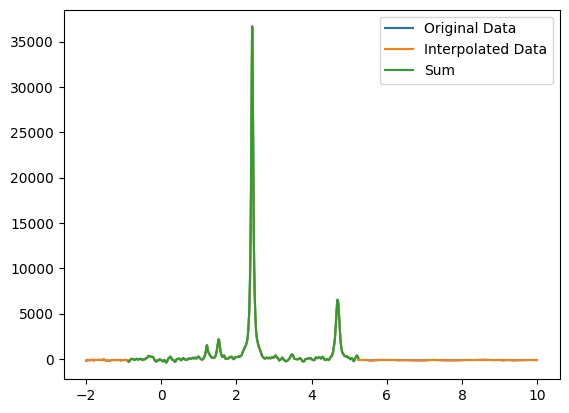

In [634]:

# Interpoliere die Werte, um die Größe des DataFrames zu erweitern
df_interpolated = interpolate_to_shape(df_filled.iloc[:, 0], df_filled.iloc[:, 1], spectrum_lenth=3000)

# Form des interpolierten DataFrames
print(df_interpolated.shape)

# Plot the interpolated data
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1])
plt.plot(df.iloc[:, 0], df.iloc[:, 1])
plt.legend(['Original Data', 'Interpolated Data', 'Sum'])
plt.show()

# Step 4: Bring Data to shape for Transformer

In [635]:
df_interpolated.shape

(3000, 2)

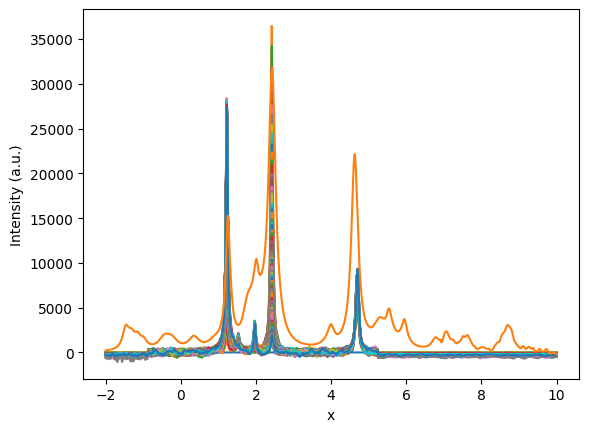

In [636]:
for i in range(df.shape[1]-1):

    df_filled = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_filled.loc[:,'x'], df_filled.loc[:,'y'], spectrum_lenth=3000)
    #plt.plot(df_filled.loc[:,'x'], df_filled.loc[:,'y'], '-', label='Original Data')
    plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], '-', label='Interpolated Data')

# data_train_tensor & y_train
pyruvate_list = [2.468, 4.7, 1.2261]
x_synth, y_synth, x0_parms, gamma_parms, height_parms = generate_random_spectrum(pyruvate_list)


plt.plot(x_synth, y_synth, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')

plt.show()

# Generate training Dataset 

In [637]:

num_samples = 10000

x_data = []
y_data = []
x0_parms_list = []
gamma_parms_list = []
height_parms_list = []
for i in range(num_samples):
    # data_train_tensor & y_train
    pyruvate_list = [2.468, 4.7, 1.2261]
    x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(pyruvate_list)
    x_data.append(x)
    y_data.append(y_noisy)
    x0_parms_list.append(x0_parms)
    gamma_parms_list.append(gamma_parms)
    height_parms_list.append(height_parms)




# Umwandeln der lists in Tensoren
x_data = torch.tensor(x_data)
data = torch.tensor(y_data) # Data: Noisy Spectra which is input to the model
x_params_tensor = torch.tensor(x0_parms_list) # Target: 
gamma_params_tensor = torch.tensor(gamma_parms_list)
height_params_tensor = torch.tensor(height_parms_list)

target = torch.cat((x_params_tensor, gamma_params_tensor, height_params_tensor), dim=1)



# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"data shape: {data.shape}")
print(f"x_params_tensor shape: {x_params_tensor.shape}")
print(f"gamma_params_tensor shape: {gamma_params_tensor.shape}")
print(f"height_params_tensor shape: {height_params_tensor.shape}")
print(f"target shape: {target.shape}")
print('\n')

x_data shape: torch.Size([10000, 3000])
data shape: torch.Size([10000, 3000])
x_params_tensor shape: torch.Size([10000, 3])
gamma_params_tensor shape: torch.Size([10000, 3])
height_params_tensor shape: torch.Size([10000, 3])
target shape: torch.Size([10000, 9])




In [638]:
def scale_data(data, target):
    """Scale the data
    
    Args:
        x_data (_type_): _description_
        y_data (_type_): _description_
    """
    # Skalieren Sie die Daten
    data_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    print(f'Before Scaling: {data.shape}')
    print(f'Before Scaling: {target.shape}')

    # Reshape the data before scaling
    data = data.reshape(data.shape[0], -1)
    target = target.reshape(target.shape[0], -1)

    print(f'After Reshaping: {data.shape}')
    print(f'After Reshaping: {target.shape}')

    # Skalieren Sie die x-Daten
    data_scaled = data_scaler.fit_transform(data)
    target_scaled = target_scaler.fit_transform(target)
    
    print(f'After Scaling: {data_scaled.shape}')
    print(f'After Scaling: {target_scaled.shape}')


    return data_scaled, target_scaled, data_scaler, target_scaler
    

# Skalieren Sie die Daten
data_scaled, target_scaled, data_scaler, target_scaler = scale_data(data, target)

Before Scaling: torch.Size([10000, 3000])
Before Scaling: torch.Size([10000, 9])
After Reshaping: torch.Size([10000, 3000])
After Reshaping: torch.Size([10000, 9])
After Scaling: (10000, 3000)
After Scaling: (10000, 9)


In [639]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Aufteilen der Daten in Trainings- und Testsets
data_train, data_tmp, target_train, target_tmp = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)
data_val, data_test, target_val, target_test = train_test_split(data_tmp, target_tmp,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                    random_state=1)


# Skalieren der Daten
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Skalieren von data train und test
data_train_sc = data_scaler.fit_transform(data_train)
data_test_sc = data_scaler.transform(data_test)
data_val_sc = data_scaler.transform(data_val)

# Skalieren von target train und test
target_train_sc = target_scaler.fit_transform(target_train)
target_test_sc = target_scaler.transform(target_test)
target_val_sc = target_scaler.transform(target_val)


# Konvertieren in Tensoren
data_train_tensor = torch.tensor(data_train_sc, dtype=torch.float32)
data_test_tensor = torch.tensor(data_test_sc, dtype=torch.float32)
data_val_tensor = torch.tensor(data_val_sc, dtype=torch.float32)
target_train_tensor = torch.tensor(target_train_sc, dtype=torch.float32)
target_test_tensor = torch.tensor(target_test_sc, dtype=torch.float32)
target_val_tensor = torch.tensor(target_val_sc, dtype=torch.float32)




# # Reshape the tensors for the model
# target_train_tensor = target_train_tensor.reshape(target_train_tensor.shape[0], -1)
# target_val_tensor = target_val_tensor.reshape(target_val_tensor.shape[0], -1)

# Überprüfen der Tensoren
print(f"Data Train Shape: {data_train_tensor.shape}")
print(f"Data Test Shape: {data_val_tensor.shape}")
print(f"Target Train Shape: {target_train_tensor.shape}")
print(f"Target Test Shape: {target_val_tensor.shape}")

Data Train Shape: torch.Size([6000, 3000])
Data Test Shape: torch.Size([2000, 3000])
Target Train Shape: torch.Size([6000, 9])
Target Test Shape: torch.Size([2000, 9])


# Multilayer Network

In [640]:
print(f"Verwende Gerät: {device}")

criterion = torch.nn.MSELoss().to(device)
learning_rate=0.01





Verwende Gerät: cuda


In [641]:
# MultiLayerPerceptron-Modell
import torch.nn as nn
import torch.optim as optim

class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(MultiLayerPerceptron, self).__init__()
                
        self.hidden_1 = nn.Linear(input_size, int(input_size/2))
        self.hidden_2 = nn.Linear(int(input_size/2), int(input_size/10))
        self.hidden_3 = nn.Linear(int(input_size/10), int(input_size/30))
        self.hidden_4 = nn.Linear(int(input_size/30), int(input_size/50))
        self.hidden_5 = nn.Linear(int(input_size/50), int(input_size/70))
        self.hidden_6 = nn.Linear(int(input_size/70), int(input_size/100))
        self.hidden_7 = nn.Linear(int(input_size/100), int(input_size/200))
        self.output = nn.Linear(int(input_size/200), output_size) # 3 parameters per peak
        self.activation=nn.PReLU()
 
    def forward(self, x):
        # if len(x.shape) >2:
        #     x = x.reshape(x.shape[0], -1)

        out1 = self.activation(self.hidden_1(x))
        out2 = self.activation(self.hidden_2(out1))
        out3 = self.activation(self.hidden_3(out2))
        out4 = self.activation(self.hidden_4(out3))
        out5 = self.activation(self.hidden_5(out4))
        out6 = self.activation(self.hidden_6(out5))
        out7 = self.activation(self.hidden_7(out6))
        
        
        return self.output(out7)

In [642]:

# Modell initialisieren
input_size = data_train_tensor.shape[1]
hidden_size = 512
output_size = len(pyruvate_list)*3  # Da wir 3 Targets mit 10000 Features haben
model = MultiLayerPerceptron(input_size, hidden_size, output_size).to(device)

# Loss und Optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


print(f'Input Size: {input_size}')
print(f'Output Size: {output_size}')

Input Size: 3000
Output Size: 9


# Implementing LSTM Model

In [643]:
class GaitGenderClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(GaitGenderClassifier, self).__init__()

        self.reduce = nn.Linear(3000, hidden_size)

        # Define LSTM with correct hidden size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)

        # Fully connected layers with corrected input sizes
        self.fc1 = nn.Sequential(
            nn.Linear(hidden_size, 128),  # Match hidden_size with the output of LSTM
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(128, 32),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )

        # Output layer
        self.output = nn.Linear(16, output_size)

    def forward(self, x):
        # Check shape before reducing
        #print(f"Input shape before reduction: {x.shape}")  # For debugging
        x = self.reduce(x)  # This should expect (batch_size, 3000)
        

        # Reshape for LSTM input
        x = x.reshape(x.shape[0], 1, -1)  # Reshape to (batch_size, seq_len, input_size)
        #print(f"Shape after reduction: {x.shape}")

        batch_size = x.shape[0]
        
        # Initialize hidden and cell states with hidden_size instead of input_size
        h_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)
        c_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)

        # Pass data through LSTM
        x, _ = self.lstm(x, (h_0, c_0))
        x = x[:, -1, :]  # Take the output from the last time step

        # Pass data through fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        # Final output
        output = self.output(x)
        return output
    
    def predict(self, X):
        '''
        Use the model to predict for the values in the test set.
        Return the prediction
        '''
        model.eval()
        with torch.no_grad():
            return model(X)


    # ------------------------------------
import torch

def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_bytes = total_params * 4  # Assuming 32-bit (4 bytes) floats
    size_in_megabytes = size_in_bytes / (1024 ** 2)  # Convert to MB
    return total_params, size_in_megabytes

# Example usage
model_size, model_size_mb = get_model_size(model)
print(f'Total parameters: {model_size}')
print(f'Model size: {model_size_mb:.2f} MB')



dropout_results = [] # storing the results of the dropout experiment

def training(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, writer, batch_size=64, patience=50, dropout_prob=0.5, log_tensorboard=True, log_dropout=True, verbose=True):

    # Set device to GPU if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

   # device = torch.device('cpu')

    # Move data and model to device
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    model.to(device)

    # Initialize best metrics and model
    best_eval_metric_val = float('inf') # Initialize the best_eval_metric
    best_val_loss = float('inf') # Initialize the best_val_loss
    best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
    patience_counter_loss = 0  # Early stopping counter
    patience_counter_metric = 0  # Early stopping counter

    # DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


    # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    train_losses, val_losses = [], [] # to visualize the drop_out_prob
    train_accuracies, val_accuracies = [], []
    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, target)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()  # Accumulate batch loss

        # Validation
        model.eval()
        with torch.no_grad():
            
            val_outputs = model(X_val)  # Forward pass

            loss_val = criterion(val_outputs, y_val)
            scheduler.step(loss_val)  # Adjust learning rate based on loss

            # calculate the training accuracy
            predictions_train = model.predict(X_train)
            accuracy_train = root_mean_squared_error(y_train.cpu(), predictions_train.cpu())

            # Calculate validation accuracy
            predictions_val = model.predict(X_val)
            rmse_val = root_mean_squared_error(y_val.cpu(), predictions_val.cpu())

            # Log to dropout_results
            if log_dropout:
              train_losses.append(epoch_loss / len(train_loader))
              val_losses.append(loss_val.item())
              train_accuracies.append(accuracy_train)
              val_accuracies.append(rmse_val)

            # Log to TensorBoard
            if log_tensorboard:
              writer.add_scalars("Loss", {"train": epoch_loss / len(train_loader), 'val': loss_val}, epoch)
              writer.add_scalars("RMSE", {"train": accuracy_train, "val": rmse_val}, epoch)
              #writer.add_scalar("Accuracy/val", rmse_val, epoch)
              writer.flush()

            # Early stopping if loss_val is increasing
            if loss_val < best_val_loss:
                best_val_loss = loss_val  # Update best val_loss
                patience_counter_loss = 0  # Reset patience counter
            else:
                patience_counter_loss += 1  # Increment if no improvement

            # Early Stopping based on if val_acc is not increasing
            if rmse_val < best_eval_metric_val:
                best_eval_metric_val = rmse_val
                best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
                patience_counter_metric = 0  # Reset patience counter if improved
            else:
                patience_counter_metric += 1

            # Early stopping check
            if (patience_counter_loss >= patience) or (patience_counter_metric >= patience):
                print(f"Early stopping at epoch {epoch+1}")
                break


        # Print status
        if verbose:
          if epoch % 19 == 0:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {loss_val:.4f} | Train RMSE: {accuracy_train:.4f}, Val RMSE: {rmse_val:.4f} |")

    dropout_results.append({'dropout_prob': dropout_prob,
                                    'train_loss': train_losses,
                                    'val_loss': val_losses,
                                    'training_RMSE': train_accuracies,
                                    'validation_RMSE': val_accuracies
                                    })
    # Load the best model
    model.load_state_dict(best_model)
    print(f"Best validation RMSE: {best_eval_metric_val:.4f}")

    writer.close()
    return model




#%tensorboard --logdir=runs


# Data preparation: ensure data shapes are correct
data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Assuming data originally has shape (num_samples, 3000)
data_val_tensor = data_val_tensor.reshape(-1, 3000)

# Check shapes before training
print("Train shape:", data_train_tensor.shape)  # Should be (num_samples, 3000)
print("Validation shape:", data_val_tensor.shape)  # Should be (num_samples, 3000)

# Prepare data for LSTM
data_train_tensor = data_train_tensor.unsqueeze(1)  # Adding seq_len dimension: shape (batch_size, 1, 3000)
data_val_tensor = data_val_tensor.unsqueeze(1)

# Define model with updated input size
input_size = 512  # Matches the second dimension after reshaping



hidden_size = 512
output_size = len(pyruvate_list) * 3  # Da wir 3 Targets mit 10000 Features haben
dropout_prob = 0.4
learning_rate = 0.01
epochs=10000

model = GaitGenderClassifier(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dropout_prob=dropout_prob).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter()

trained_model = training(model=model,
                           X_train=data_train_tensor,
                           y_train=target_train_tensor,
                           X_val=data_val_tensor,
                           y_val=target_val_tensor,
                           criterion=criterion,
                           optimizer=optimizer,
                           epochs=epochs,
                           writer=writer,
                           dropout_prob=dropout_prob,
                           log_tensorboard=True,
                           log_dropout=False,
                           verbose=True)


Total parameters: 4992422
Model size: 19.04 MB
Train shape: torch.Size([6000, 3000])
Validation shape: torch.Size([2000, 3000])
| Epoch 1 | Train Loss: 0.1204, Validation Loss: 0.0842 | Train RMSE: 0.2890, Val RMSE: 0.2902 |
| Epoch 20 | Train Loss: 0.0834, Validation Loss: 0.0841 | Train RMSE: 0.2887, Val RMSE: 0.2900 |
| Epoch 39 | Train Loss: 0.0833, Validation Loss: 0.0841 | Train RMSE: 0.2887, Val RMSE: 0.2899 |
| Epoch 58 | Train Loss: 0.0834, Validation Loss: 0.0841 | Train RMSE: 0.2887, Val RMSE: 0.2899 |
Early stopping at epoch 65
Best validation RMSE: 0.2899


In [644]:
# #Training function
# def train_model(model, data_train_tensor, target_train_tensor, criterion, optimizer, epochs, device):
#     model.train()
#     model.to(device)
#     data_train_tensor = data_train_tensor.to(device)
#     target_train_tensor = target_train_tensor.to(device)

#     for epoch in range(epochs):
#         target_train_pred = model(data_train_tensor)
#         optimizer.zero_grad()
#         print(target_train_pred.shape)
#         print(target_train_tensor.shape)
#         train_loss = criterion(target_train_pred, target_train_tensor)
        
#         train_loss.backward()

#         optimizer.step()

#         if (epoch % 100==99):
#             print("Epoch: %d, loss: %1.5f" % (epoch, train_loss.item()))

In [645]:
data_train_tensor.shape

torch.Size([6000, 1, 3000])

In [646]:
def predict(model, X):
    '''
    Use the model to predict for the values in the test set.
    Return the prediction
    '''
    model.eval()
    with torch.no_grad():
        return model(X)

In [647]:
# # Bring all tensors back to the CPU
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")

data_train_tensor.shape

torch.Size([6000, 1, 3000])

In [648]:
# Vorhersagen und Rückskalierung
model.to("cpu")
target_train_pred = predict(model, data_train_tensor)
target_val_pred = predict(model, data_val_tensor)

# Bring all tensors back to the CPU and to numpy
target_train_pred = target_train_pred.cpu().detach()
target_val_pred = target_val_pred.cpu().detach()
data_train_tensor = data_train_tensor.cpu().detach()
data_val_tensor = data_val_tensor.cpu().detach()


print(f'target_train_pred: {target_train_pred.shape}')
print(f'target_val_pred: {target_val_pred.shape}')



# Rescale the data
target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred)
target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred)

# Reshape the data
target_train_pred = target_train_pred_rescaled.reshape(target_train_pred_rescaled.shape[0], -1)
target_val_pred = target_val_pred_rescaled.reshape(target_val_pred_rescaled.shape[0], -1)




print(f'target_train_pred_rescaled: {target_train_pred.shape}')
print(f'target_val_pred_rescaled: {target_val_pred.shape}')

target_train_pred: torch.Size([6000, 9])
target_val_pred: torch.Size([2000, 9])
target_train_pred_rescaled: (6000, 9)
target_val_pred_rescaled: (2000, 9)


data_train: (6000, 3000)
data_val: (2000, 3000)
target_train: (6000, 9)


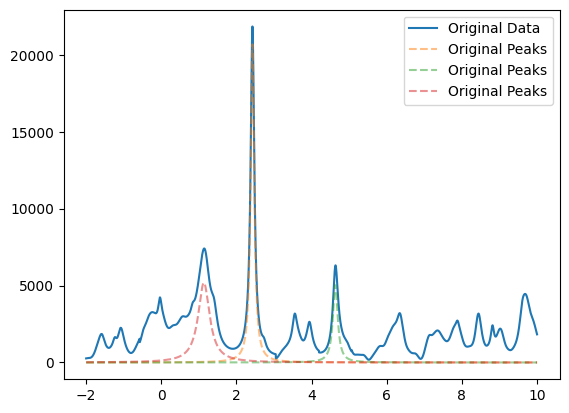

In [649]:
# bring the data back to the cpu
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")
data_test_tensor = data_test_tensor.to("cpu")

target_train_tensor = target_train_tensor.to("cpu")
target_test_tensor = target_test_tensor.to("cpu")
target_val_tensor = target_val_tensor.to("cpu")

data_train_tensor = data_train_tensor.squeeze(1)
data_val_tensor = data_val_tensor.squeeze(1)
# scale the data back
data_train = data_scaler.inverse_transform(data_train_tensor)
data_val = data_scaler.inverse_transform(data_val_tensor)
target_train = target_scaler.inverse_transform(target_train_tensor)
target_test = target_scaler.inverse_transform(target_test_tensor)

print(f'data_train: {data_train.shape}')
print(f'data_val: {data_val.shape}')
print(f'target_train: {target_train.shape}')
#print(f'target_test: {target_test.shape}')


x0_parms_train, gamma_parms_train, height_parms_train = np.split(target_train, len(pyruvate_list), axis=1)
x0_parms_test, gamma_parms_test, height_parms_test = np.split(target_test, len(pyruvate_list), axis=1)



n = 10
x = x_data[n]
# plot the data
#plt.plot(x, data_train[n, :], '-', label='Original Data')
# for x0, gamma, height in zip(x0_parms_train[n], gamma_parms_train[n], height_parms_train[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)

plt.plot(x, data_test[n, :], '-', label='Original Data')
for x0, gamma, height in zip(x0_parms_test[n], gamma_parms_test[n], height_parms_test[n]):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)   

plt.legend()
plt.show()

# Validate on real Data

In [650]:
# Use a dataframe to collect general evaluation results
results = pd.DataFrame()

# We will reuse this function. Hence we copy it to mads_dl.py
def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
    '''
    Create a table with evaluation results
    of a regression experiment
    '''
    for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
        mse=mean_squared_error(actual, predicted)
        results= pd.concat([results, pd.DataFrame([{
            "algorithm": algorithm, 
            "dataset": dataset,
            "MSE": mse,
            "RMSE": math.sqrt(mse),
            "MAE": mean_absolute_error(actual, predicted),
            "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
            "params": num_params
        }])], ignore_index=True)   
    return results


# Test on Data

In [651]:
path_list

['/home/generalpegasus/Documents/Programme/MoinCC-AI4metabolomics/Data/FA_20231113_2H_yeast_Pyruvate-d3_1.csv']

(1, 3000)


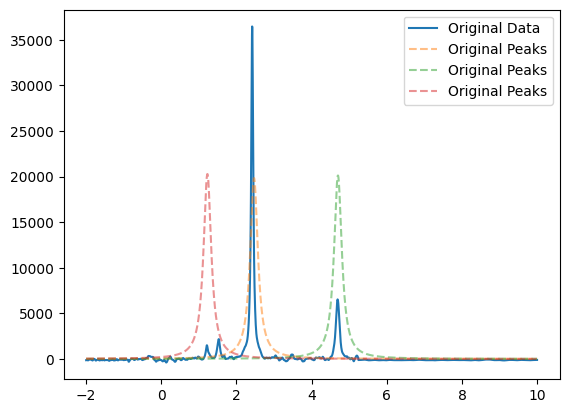

In [652]:
df = pd.read_csv(path_list[0]) 
df['sum'] = df.iloc[:,1:].sum(axis=1)
x = df.iloc[:,0]
y = df.iloc[:, 100]

# fill the data
df_fill = fill_df(df.iloc[:, 0:2])

# interpolate the data
df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)

x_val = df_interpolated.iloc[:, 0]
y_val = df_interpolated.iloc[:, 1]

# scale the data
y_val_sc = data_scaler.transform(y_val.values.reshape(1, -1))
print(y_val_sc.shape)

# convert to tensor
y_val_tensor = torch.tensor(y_val_sc, dtype=torch.float32)

# predict the data
target_val_pred = predict(model, y_val_tensor)

# bring the data back to the cpu
target_val_pred = target_val_pred.cpu().detach().numpy()

# rescale the data
target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred)

# reshape the data
target_val_pred = target_val_pred_rescaled.reshape(target_val_pred_rescaled.shape[0], -1)

x0_parms_val, gamma_parms_val, height_parms_val = np.split(target_val_pred, 3, axis=1)


# plot the data
plt.plot(x_val, y_val, '-', label='Original Data')
for x0, gamma, height in zip(x0_parms_val[0], gamma_parms_val[0], height_parms_val[0]):
    lorentz = lorentzian(x_val, x0, gamma, height)
    plt.plot(x_val, lorentz, '--', label='Original Peaks', alpha=0.5)
plt.legend()
plt.show()
